In [1]:
import QuickDraw as Data
from kaggleguy import KaggleGuy3
from torchvision.models import *
import torch
from torch import nn


################################
########## refreshing ##########
################################


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [3]:
# model = KaggleGuy3(Data.input_size, Data.num_classes).to(device)
model = get_model("efficientnet_v2_s", num_classes=Data.num_classes, dropout=.2)
model.features[0][0] = nn.Conv2d(1, 24, 3, 2, 1, bias=False)
# model = get_model("mobilenet_v3_large", num_classes=Data.num_classes)
# model.features[0][0] = nn.Conv2d(1, 16, 3, 2, 1, bias=False)
model.to(device)
model.name = "efficientnet_v2_s"
# model.name = "mobilenet_v3_large"
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}")
loss_fn = nn.CrossEntropyLoss()
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Number of parameters: 20,619,001


In [4]:
state = torch.load("./checkpoints/temp-efficientnet_v2_s-QuickDraw")
model.load_state_dict(state["model"])
optimizer.load_state_dict(state["optimizer"])

In [5]:
train = Data.train_dataloader(512)
test = Data.test_dataloader(512)

In [6]:
print(torch.sum(test.dataset[0][0]), test.dataset[0][1])

tensor(112.5490) 42


In [7]:
print(test_loop(test, model, loss_fn))

NameError: name 'test_loop' is not defined

In [7]:
for pg in optimizer.param_groups:
    pg["lr"] = 1e-4
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

In [8]:
def test_loop(dataloader, model, loss_fn, augment=lambda x: x):
    model.eval()
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    size = 0

    with torch.no_grad():
        for X, y in dataloader:
            size += y.shape[0]
            X = X.to(device)
            X = augment(X)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error: \nAccuracy: {(100*correct):>0.2f}%, Loss: {test_loss:>8f}")

    return correct * 100, test_loss

In [9]:
def train_iters(iterator, batch_size, model, loss_fn, optimizer, num_samples, augment=lambda x: x):
    num_batches = num_samples // batch_size
    print_interval = -(num_batches // -10)
    total_loss, correct = 0, 0

    model.train()
    batch = 0
    for X, y in iterator:
        if batch == num_batches:
            break
        batch += 1
        X = X.to(device)
        X = augment(X)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        
        total_loss += loss.item() * batch_size
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        loss.backward()
        optimizer.step()

        if batch % print_interval == 0:
            loss = loss.item()
            print(
                f"| loss: {loss:>7f} [{batch + 1}/{num_batches}] |",
                end="\t",
                flush=True,
            )
    avg_loss = total_loss / (num_batches * batch_size)
    acc = correct / (num_batches * batch_size) * 100


    print(f"\nTrain Error: \nAccuracy: {(acc):>0.2f}%, Loss: {avg_loss:>8f}")

    return acc, avg_loss

In [10]:
max_epochs = 60
best = 0
delta = .01
quit = -1
epoch_size = 345_000
reset_epoch = int((len(train.dataset) / epoch_size - 2) * .95)

train_losses = []
train_accs = []
test_losses = []
test_accs = []

iterator = iter(train)

In [11]:
reset_epoch

92

In [12]:
for epoch in range(320):
    if epoch % reset_epoch == 0:
        iterator = iter(train)

    print(f"\nEpoch {epoch + 1}\n---------------------------------------------------")
    train_acc, train_loss = train_iters(iterator, 512, model, loss_fn, optimizer, epoch_size)
    test_acc, test_loss = test_loop(test, model, loss_fn)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    if test_acc < best + delta:
        no_improve_epochs += 1
    else:
        no_improve_epochs = 0
    if no_improve_epochs == quit:
        break


Epoch 1
---------------------------------------------------
| loss: 0.976182 [69/673] |	| loss: 0.924368 [137/673] |	| loss: 0.899562 [205/673] |	| loss: 0.887170 [273/673] |	| loss: 0.940761 [341/673] |	| loss: 0.890542 [409/673] |	| loss: 0.885350 [477/673] |	| loss: 1.028436 [545/673] |	| loss: 1.013577 [613/673] |	
Train Error: 
Accuracy: 76.48%, Loss: 0.920254

Test Error: 
Accuracy: 76.79%, Loss: 0.909563

Epoch 2
---------------------------------------------------
| loss: 1.027305 [69/673] |	| loss: 0.845723 [137/673] |	| loss: 0.865291 [205/673] |	| loss: 0.806973 [273/673] |	| loss: 1.035313 [341/673] |	| loss: 0.926635 [409/673] |	| loss: 0.982715 [477/673] |	| loss: 0.855187 [545/673] |	| loss: 0.838999 [613/673] |	
Train Error: 
Accuracy: 76.35%, Loss: 0.920221

Test Error: 
Accuracy: 76.80%, Loss: 0.911871

Epoch 3
---------------------------------------------------
| loss: 0.848078 [69/673] |	| loss: 1.123069 [137/673] |	| loss: 0.909472 [205/673] |	| loss: 0.876032 [273

KeyboardInterrupt: 

In [14]:
import matplotlib.pyplot as plt

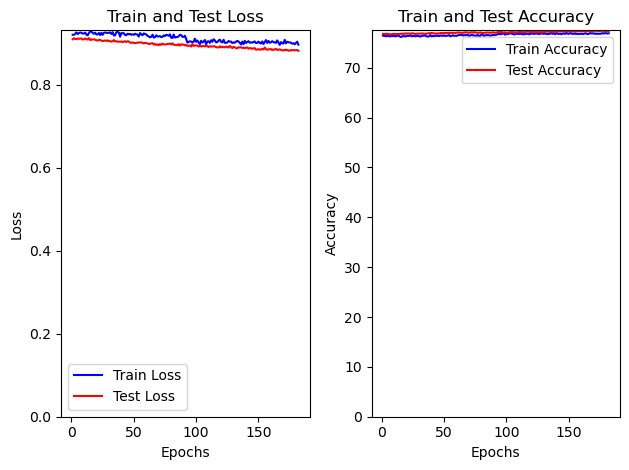

In [15]:
epochs = range(1, len(train_losses) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, test_losses, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.gca().set_ylim([0, None])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
plt.plot(epochs, test_accs, 'r-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()
plt.gca().set_ylim([0, None])

plt.tight_layout()
plt.show()

In [16]:
cp = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "best": best,
}

filename = "temp-" + model.name + "-" + "QuickDraw"
torch.save(cp, "./checkpoints/" + filename)
print(f'Saving final model with name "{filename}".')

Saving final model with name "temp-efficientnet_v2_s-QuickDraw".


In [147]:
testys = [t[1] for t in test.dataset]

In [148]:
len(testys)

138000

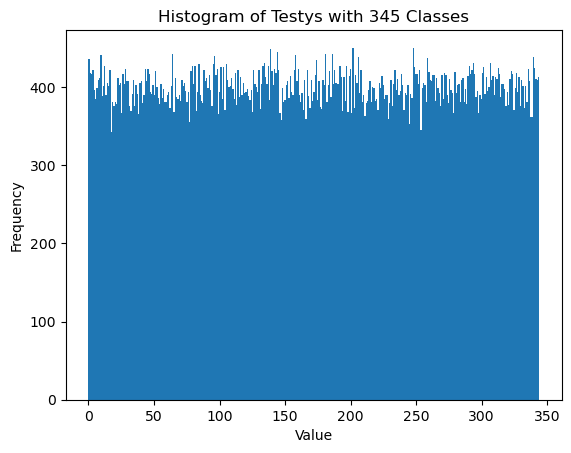

In [150]:
plt.hist(testys, bins=345)
plt.title('Histogram of Testys with 345 Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [157]:
from sklearn.metrics import confusion_matrix
import numpy as np

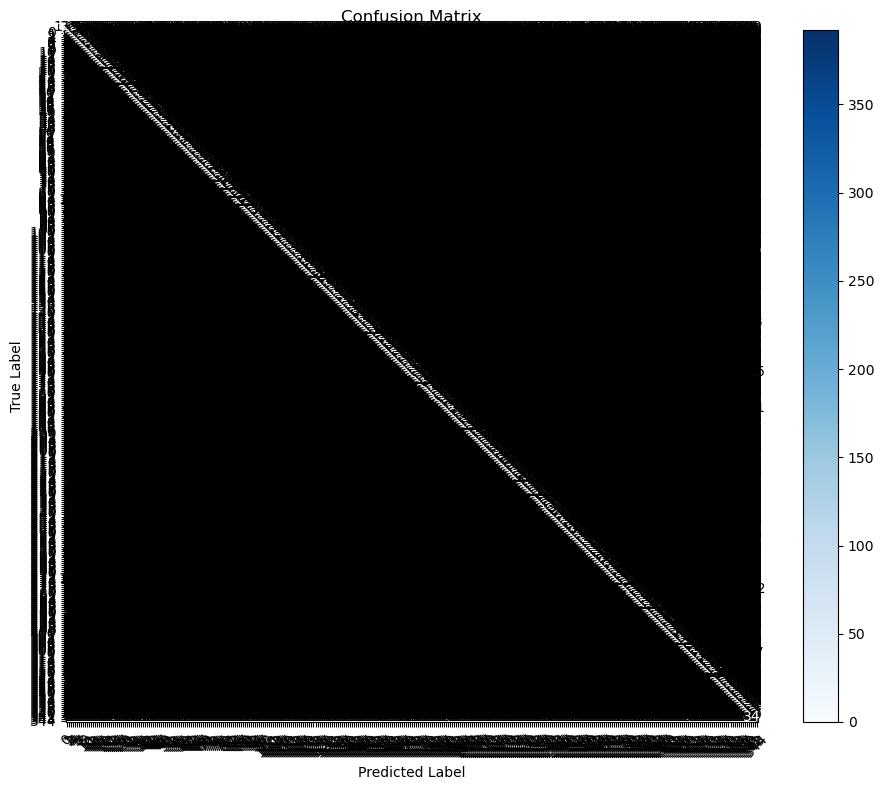

In [158]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming your model and dataloader are named `model` and `test` respectively
# model = ...
# test = ...

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test:
        # Move inputs and labels to the appropriate device (e.g., GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted labels (assuming the model outputs logits)
        _, predicted = torch.max(outputs, 1)
        
        # Append true and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [161]:
cm.shape

(345, 345)

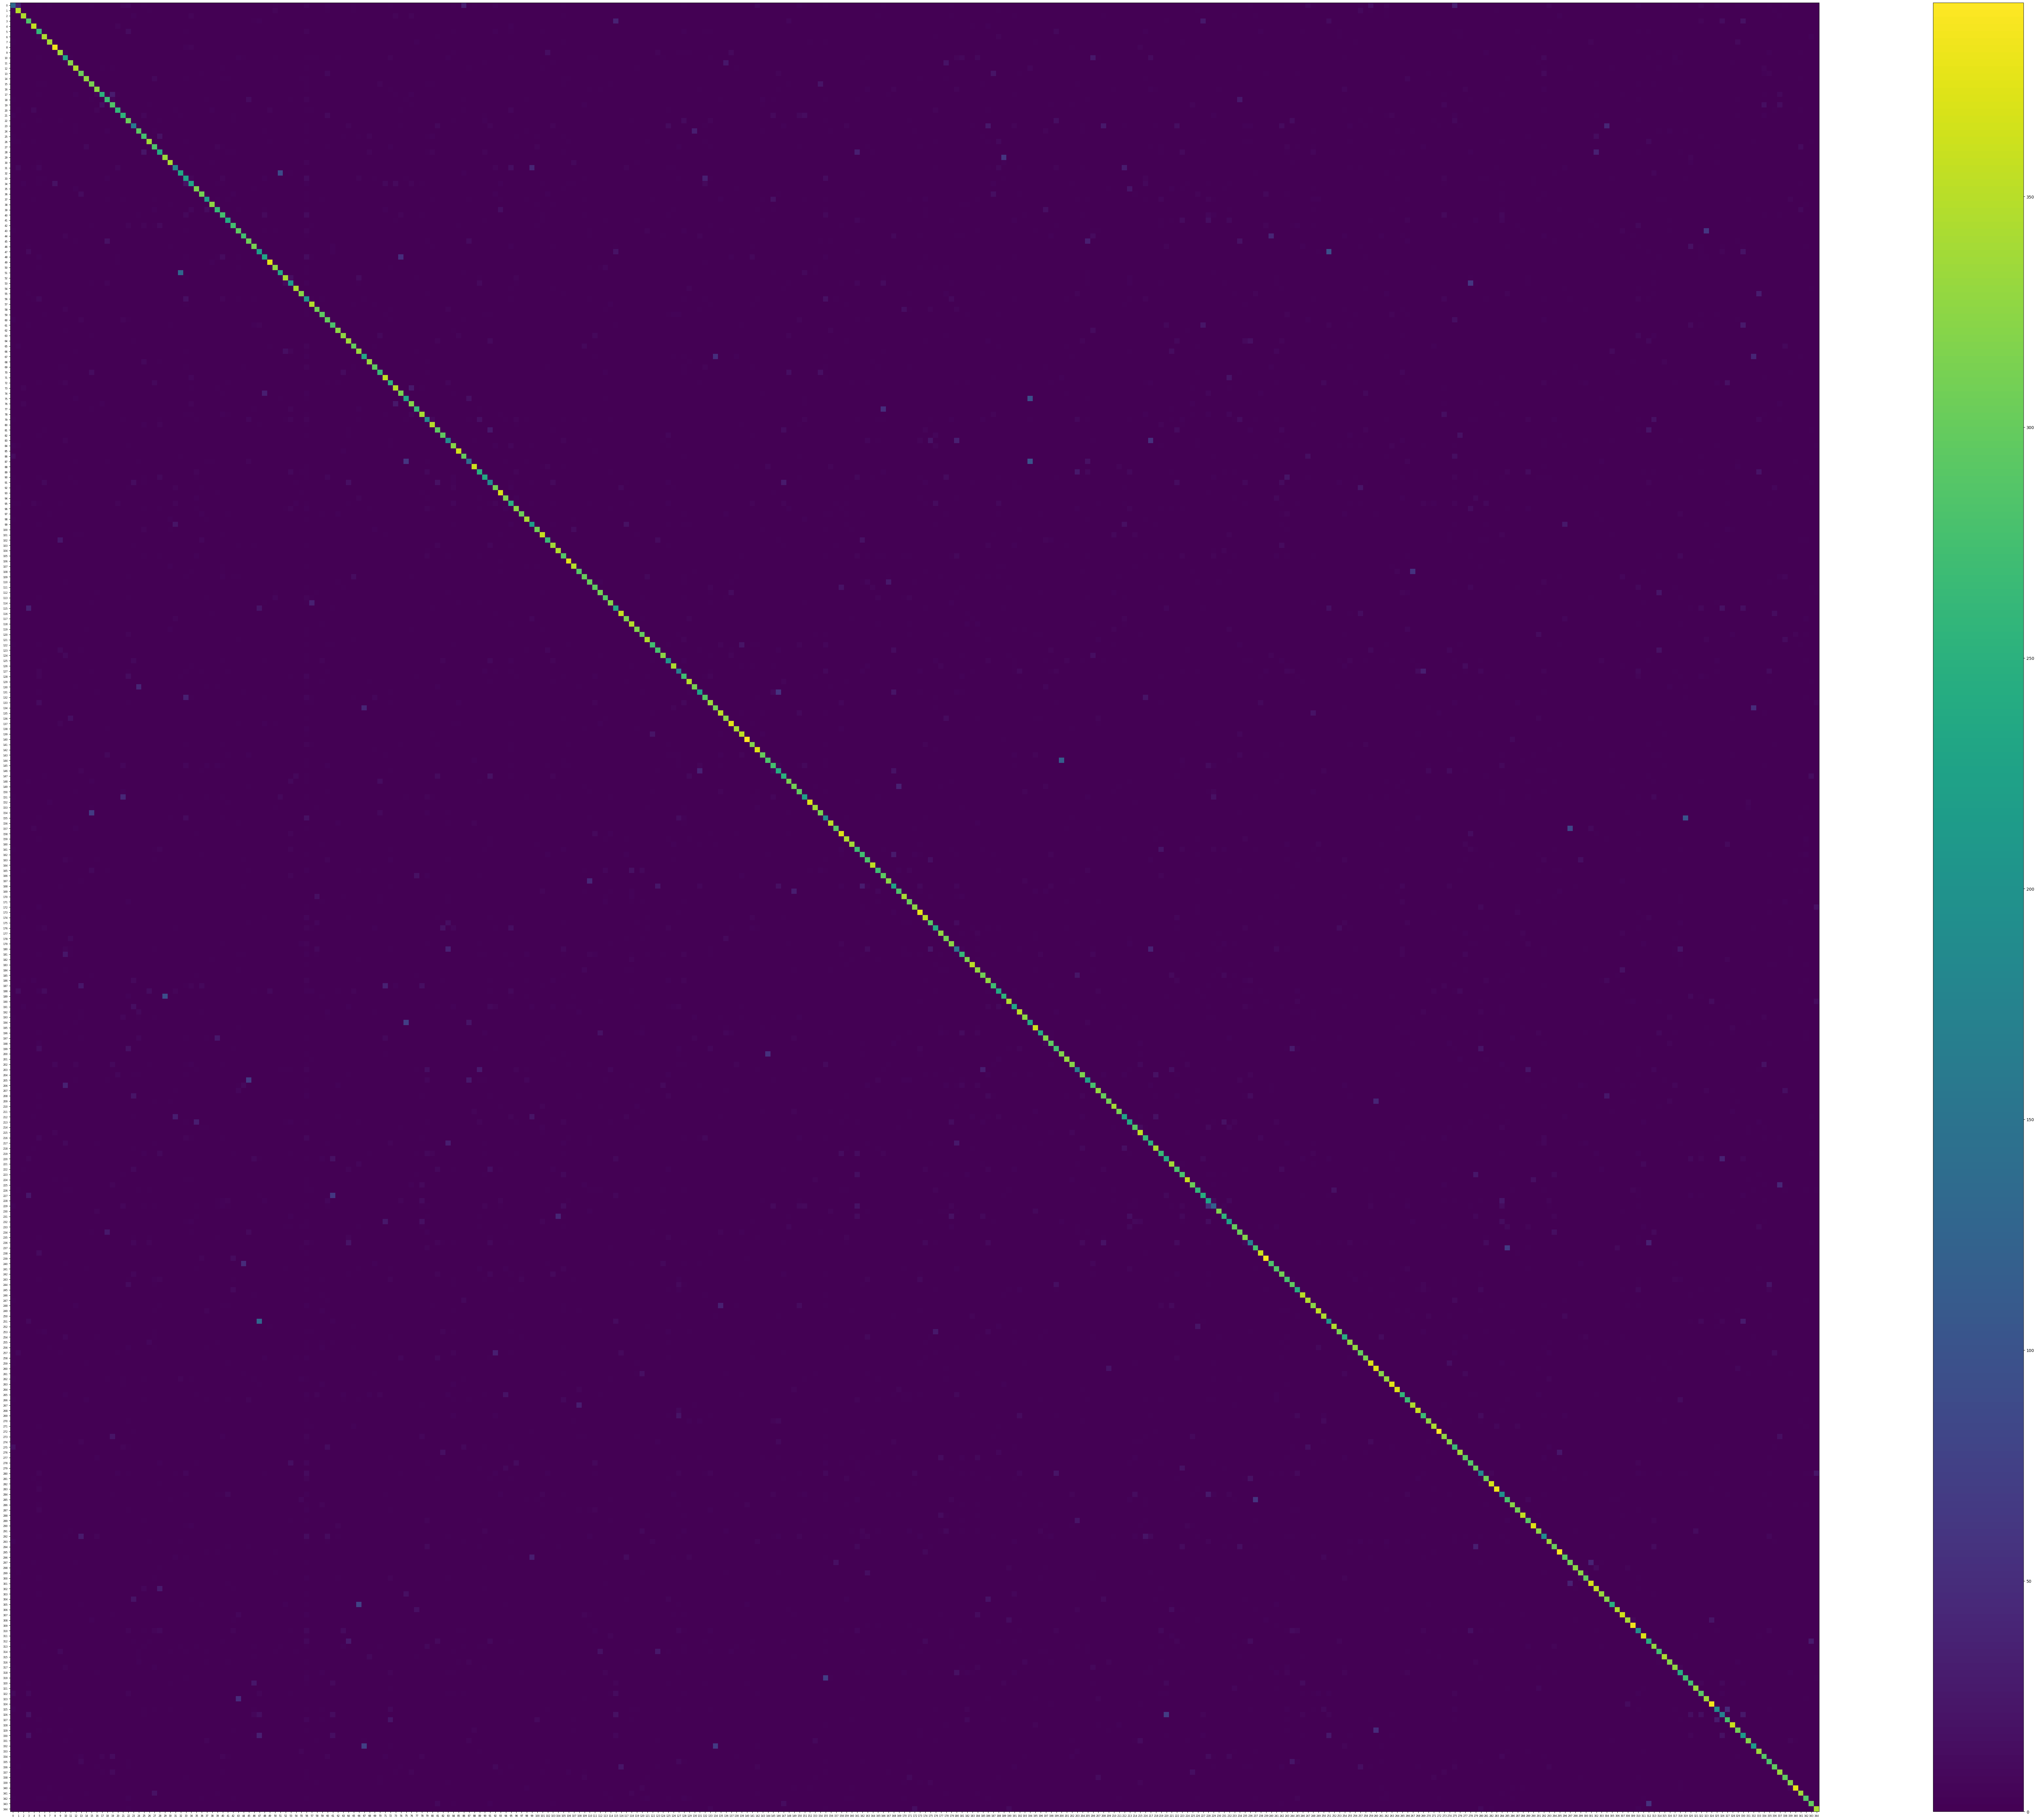

In [168]:
plt.figure(figsize=(100, 80))
ticks=np.linspace(0, 344,num=345)
plt.imshow(cm, interpolation='none')
plt.colorbar()
plt.xticks(ticks,fontsize=6)
plt.yticks(ticks,fontsize=6)
plt.grid(False)
plt.show()

In [1]:
import os

In [2]:
files = os.listdir("data/QuickDraw/")

In [3]:
files = [file.split(".")[0] for file in files]

In [196]:
files[194]

'mug'

In [176]:
cmsorted = np.dstack(np.unravel_index(np.argsort(cm.ravel())[::-1], (345, 345)))

In [184]:
cmsorted = cmsorted[0, :, :]

In [191]:
with np.printoptions(threshold=np.inf):
    print(cmsorted)

[[140 140]
 [272 272]
 [239 239]
 [295 295]
 [324 324]
 [309 309]
 [  8   8]
 [283 283]
 [173 173]
 [340 340]
 [263 263]
 [137 137]
 [260 260]
 [ 49  49]
 [106 106]
 [290 290]
 [142 142]
 [264 264]
 [158 158]
 [152 152]
 [311 311]
 [259 259]
 [ 93  93]
 [282 282]
 [301 301]
 [ 85  85]
 [307 307]
 [238 238]
 [195 195]
 [328 328]
 [ 88  88]
 [116 116]
 [224 224]
 [268 268]
 [101 101]
 [288 288]
 [  4   4]
 [215 215]
 [164 164]
 [249 249]
 [139 139]
 [ 71  71]
 [174 174]
 [302 302]
 [246 246]
 [183 183]
 [192 192]
 [156 156]
 [135 135]
 [  1   1]
 [ 80  80]
 [129 129]
 [ 73  73]
 [118 118]
 [107 107]
 [ 57  57]
 [252 252]
 [306 306]
 [104 104]
 [121 121]
 [267 267]
 [  2   2]
 [247 247]
 [ 12  12]
 [  6   6]
 [159 159]
 [250 250]
 [126 126]
 [190 190]
 [315 315]
 [ 30  30]
 [271 271]
 [218 218]
 [344 344]
 [ 54  54]
 [ 78  78]
 [138 138]
 [ 52  52]
 [308 308]
 [  7   7]
 [170 170]
 [ 98  98]
 [  9   9]
 [160 160]
 [153 153]
 [103 103]
 [276 276]
 [210 210]
 [221 221]
 [ 26  26]
 [341 341]

In [197]:
for p in cmsorted:
    if p[0] != p[1]:
        print(files[p[0]], files[p[1]])

cake birthday cake
school bus bus
hexagon octagon
hurricane tornado
cup mug
coffee cup mug
bus school bus
motorbike bicycle
birthday cake cake
jacket sweater
telephone cell phone
violin cello
mug coffee cup
tornado hurricane
truck pickup truck
house barn
paint can bucket
radio stereo
violin guitar
police car car
calendar spreadsheet
broccoli tree
bicycle motorbike
cup coffee cup
stereo radio
face smiley face
golf club hockey stick
crayon pencil
octagon hexagon
zebra tiger
pool pond
cello guitar
computer laptop
bush cloud
guitar violin
tree broccoli
underwear shorts
rake broom
trombone trumpet
leaf feather
hot tub bathtub
pizza wheel
guitar cello
bear teddy-bear
bird duck
postcard envelope
pants shorts
broom rake
cello violin
goatee beard
sweater t-shirt
hockey stick golf club
ambulance firetruck
marker pencil
t-shirt sweater
marker crayon
pickup truck truck
hot air balloon light bulb
paintbrush asparagus
moon circle
bench table
sandwich hamburger
grapes blackberry
crayon marker
van bus

In [209]:
from torchvision.transforms import v2
from PIL import Image

In [237]:
def predict(file, model):
    transform = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    with Image.open(file) as image:
        img_tensor = transform(image)
        plt.subplot(2, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
    img_tensor, _ = torch.max(img_tensor, dim=0, keepdim=True)
    plt.subplot(2, 2, 2)
    plt.imshow(img_tensor.squeeze(), cmap="gray")
    img_tensor = img_tensor.unsqueeze(0).to(device)
    plt.axis("off")
    plt.subplot(2, 2, 3)
    plt.imshow(img_tensor.squeeze().to("cpu"), cmap="gray")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)[0, :]
        logits = torch.softmax(logits, 0, None)
        topk = 3
        probs, ys = torch.topk(logits, topk)
        probs = probs
        ys = ys
        for i in range(topk):
            print(f"{files[ys[i].item()]}: {probs[i].item():.4f}")

In [238]:
import random

In [245]:
random.choice(files)

'drill'

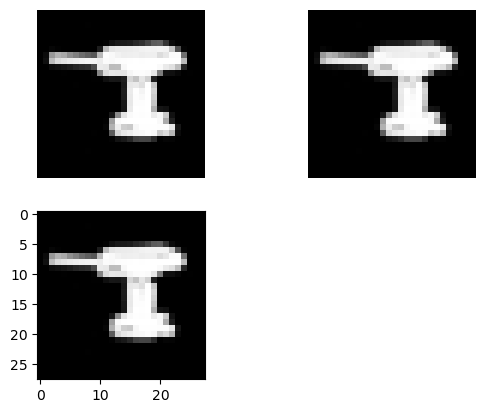

drill: 0.1852
tornado: 0.1323
hourglass: 0.0780


In [246]:
predict("input.jpg", model)

In [260]:
next(iter(test))[0].shape

torch.Size([256, 1, 28, 28])

In [253]:
import torch.onnx

In [333]:
model.eval()
x = torch.randn(256, 1, 28, 28, requires_grad=True).to(device)
torch_out = model(x)
torch.onnx.export(model, x, "efficientnet_v2_s_quickdraw.onnx", export_params=True, do_constant_folding=True, input_names = ["input"], output_names = ["output"], dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})

In [334]:
import onnx

In [335]:
onnx_model = onnx.load("efficientnet_v2_s_quickdraw.onnx")
onnx.checker.check_model(onnx_model)

In [336]:
import onnxruntime

In [337]:
ort_session = onnxruntime.InferenceSession("efficientnet_v2_s_quickdraw.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 27439 / 88320 (31.1%)
Max absolute difference: 0.00873089
Max relative difference: 21.423403
 x: array([[ 2.991809,  1.538613, -0.66837 , ...,  1.795276,  3.486271,
         2.232782],
       [ 0.513923, -1.634504, -2.503112, ..., -0.598364,  1.094456,...
 y: array([[ 2.994104,  1.540605, -0.667211, ...,  1.79607 ,  3.487074,
         2.234005],
       [ 0.516132, -1.63145 , -2.501637, ..., -0.59546 ,  1.095665,...